# Import Libraries and Dependencies
Import necessary libraries (pandas, numpy, matplotlib) and the BAB framework components (`FundingDataBundle`, `BABWalkForwardRunner`, etc.). Ensure `binance_data_loader` is imported for data ingestion.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from bab_framework import (
    FundingDataBundle, 
    compute_sharpe,
    BettingAgainstBetaParams,
    BABWalkForwardRunner,
    WeightingModel,
    BettingAgainstBetaWeighting
)
from binance_data_loader import BinanceDataLoader

# Ensure plots are displayed inline
%matplotlib inline

# Define BetaQuintileLongOnlyWeighting Class
Implement a custom weighting class `BetaQuintileLongOnlyWeighting` inheriting from `WeightingModel`. This class will:
1. Accept a `target_quintile` index (0=Lowest Beta, 4=Highest Beta).
2. Sort all tradeable assets by their forecasted Beta.
3. Select the subset of assets corresponding to the target quintile.
4. Assign weights (equal-weighted in this implementation) to this subset.
5. Scale the final weights such that the portfolio's aggregate ex-ante beta equals the target (1.0).

In [15]:
class BetaQuintileLongOnlyWeighting(WeightingModel):
    def __init__(self, target_quintile: int, n_quintiles: int = 5):
        self.target_quintile = target_quintile
        self.n_quintiles = n_quintiles

    def weights(self, idx, signals, bundle, universe_mask, params):
        beta = signals["beta"]
        
        # Filter for valid beta
        # We also intersect with universe_mask (price availability etc.)
        valid_idx = np.where(universe_mask & np.isfinite(beta) & (beta > 0))[0] 
        
        # If not enough assets, return zero weights
        if len(valid_idx) < self.n_quintiles:
            return np.zeros(len(beta))
            
        beta_vals = beta[valid_idx]
        sorted_args = np.argsort(beta_vals) # Low to High
        sorted_indices = valid_idx[sorted_args]
        
        # Split into quintiles
        chunks = np.array_split(sorted_indices, self.n_quintiles)
        
        # Select target quintile
        # 0 = Lowest Beta, 4 = Highest Beta
        selected_indices = chunks[self.target_quintile]
        
        if len(selected_indices) == 0:
            return np.zeros(len(beta))
            
        # Equal Weight within Quintile
        # Start with raw equal weights
        raw_weights = np.zeros(len(beta))
        raw_weights[selected_indices] = 1.0 / len(selected_indices)
        
        # Calculate Current Portfolio Beta (Weighted Average Beta)
        # Port Beta = sum(w_i * beta_i)
        current_port_beta = np.sum(raw_weights[selected_indices] * beta[selected_indices])
        
        # Scale to Target Beta = 1.0
        # We need sum(w_final * beta) = target_beta
        # w_final = k * raw_weights
        # k * current_port_beta = target_beta
        # k = target_beta / current_port_beta
        
        target_beta = getattr(params, "target_side_beta", 1.0)
        
        if current_port_beta < 1e-6:
             # If portfolio beta is effectively zero (unlikely with positive betas), we can't scale to 1.
             return np.zeros(len(beta))
             
        k = target_beta / current_port_beta
        final_weights = raw_weights * k
        
        # Apply Leverage Cap Check
        leverage_cap = getattr(params, "leverage_cap", 5.0)
        total_leverage = np.sum(final_weights)
        
        if total_leverage > leverage_cap:
             # Cap leverage, which means we miss beta target but stay safe
             scale_down = leverage_cap / total_leverage
             final_weights *= scale_down
             
        return final_weights

# Initialize Data Bundle and Strategy Parameters
Load the BAB data bundle and define the necessary simulation parameters, including start dates, end dates, and transaction costs. Checks `target_side_beta=1.0`.

In [16]:
# 1. Load Data
loader = BinanceDataLoader(
    data_directory="/Users/chinjieheng/Documents/data/binance_1Hdata",
    funding_rate_directory="/Users/chinjieheng/Documents/data/binance_fundingrate_data",
    timeframe='1h',
    min_records=90,
    min_volume=1e6,
    start_date="2023-01-01",
    end_date=None
)

price_hf = loader.get_price_matrix()
returns_df_hf = price_hf.pct_change()

# Prepare Daily Data
price_daily = price_hf.resample('D').last()
returns_daily = price_daily.pct_change()

# Process Funding Data
funding_long = loader.get_funding_long_form()
daily_funding = (
    funding_long['fundingRate']
    .unstack(level=0)
    .sort_index()
    .resample('D').sum(min_count=1)
)

# Get Volume Data (30d Rolling Mean)
daily_volume = loader.get_volume_matrix(vol_30d=True)
daily_volume = daily_volume.reindex(price_daily.index).fillna(0.0)

# Create Bundle
bundle = FundingDataBundle(
    price_df=price_daily,
    funding_df=daily_funding,
    returns_df=returns_daily,
    volume_df=daily_volume,
    returns_df_hf=returns_df_hf,
    hf_window_multiplier=24,
    min_hist_days=30,
    hf_resample_rule='D'
)

# 2. Define Base Parameters
base_params = BettingAgainstBetaParams(
    beta_window=30,
    portfolio_size_each_side=100, # Not strictly used in our custom weighting but kept for safety
    target_side_beta=1.0,         # Scaled beta to 1.0
    beta_tolerance=0.001,
    gross_exposure_limit=1.0,     # Standard BAB limits
    leverage_cap=5.0,
    beta_type="btc",
    tc_bps=5,
    use_shrinkage=True,
    prior_beta_window=90,
    min_weight=0.0,
    max_weight=1.0,
    weighting_method="long_only_quintile", # Custom identifier
    max_funding_short=0.1,
    min_funding_long=-0.1,
    volatility_scaling=False,     # We are doing Equal Weight scaled to Beta 1
    volume_filter_threshold=0.0   # No volume filter (unless implicit in loader)
)

Loading Binance data from /Users/chinjieheng/Documents/data/binance_1Hdata (timeframe=1h)...
Found 623 USDT trading pairs
Using a 720-bar rolling window for 30d volume checks
✓ BTCUSDT loaded successfully with 27105 records, avg volume: 636,432,576
Loaded 574 cryptocurrencies
Filtered 46 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix (Memory Optimized)...
Matrix shape: (27105, 574)
Precomputed returns matrix shape: (27105, 574)
Date range: 2023-01-01 00:00:00 to 2026-02-03 08:00:00
Loading funding rate data from /Users/chinjieheng/Documents/data/binance_fundingrate_data...
Found 625 funding rate files
Loaded funding rates for 574 symbols


/var/folders/4j/50_b76mn3qj360c47nzkyxdc0000gn/T/ipykernel_2876/537553529.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df_hf = price_hf.pct_change()
/var/folders/4j/50_b76mn3qj360c47nzkyxdc0000gn/T/ipykernel_2876/537553529.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_daily = price_daily.pct_change()


Building volume matrix (volume_30d) for 574 tickers over 27105 dates...


# Backtest Beta Quintile Strategies
Run a loop to instantiate the `BetaQuintileLongOnlyWeighting` strategy for each quintile (0 to 4), execute the backtest for each, and store the resulting performance statistics.
Quintile 0 is the Lowest Beta (Best 'Signal' for BAB Long).
Quintile 4 is the Highest Beta (Worst 'Signal' for BAB Long, usually Short).

In [17]:
quintile_results = {}
quintile_returns = {}
quintile_stats = []

n_quintiles = 5

for q in range(n_quintiles):
    print(f"\nRunning Long-Only Backtest for Beta Quintile {q+1}/{n_quintiles}...")
    
    # Define a specific class for this quintile to work with runner instantiation
    class SpecificBetaWeighting(BetaQuintileLongOnlyWeighting):
        def __init__(self):
            super().__init__(target_quintile=q, n_quintiles=n_quintiles)
            
    runner = BABWalkForwardRunner(
        bundle=bundle,
        params_grid=[base_params], 
        train_span=90,
        test_span=90,
        step_span=90,
        score_mode="sharpe",
        mode='expanding'
    )
    
    # Inject our custom weighting class
    runner.weighting_cls = SpecificBetaWeighting
    
    # Run
    wf_df, oos_returns, oos_equity, oos_price_ret, oos_funding_ret, positions_df, detailed_df = runner.run()

    # Generate Report
    print(f"\n--- Report for Beta Quintile {q+1} ---")
    
    # Description
    desc = f"Q{q+1} (Lowest Beta)" if q == 0 else (f"Q{q+1} (Highest Beta)" if q == n_quintiles-1 else f"Q{q+1}")
    
    # Use report() but turn off plot inside loop to save space, we plot aggregate later
    rep = runner.report(
        wf_df=wf_df,
        oos_returns=oos_returns,
        oos_equity=oos_equity,
        oos_price_returns=oos_price_ret,
        oos_funding_returns=oos_funding_ret,
        detailed_df=detailed_df,
        plot=False, 
        fig_dir=None,
        title_suffix=f"Beta Quintile {q+1}"
    )
    
    # Store results
    quintile_results[q] = oos_equity
    quintile_returns[q] = oos_returns
    
    # Compute stats
    if not oos_returns.empty:
        sharpe = compute_sharpe(oos_returns)
        total_ret = (oos_equity.iloc[-1] - 1.0) if not oos_equity.empty else 0.0
        
        running_max = oos_equity.expanding().max()
        dd = (oos_equity - running_max) / running_max
        max_dd = dd.min()
    else:
        sharpe = np.nan
        total_ret = 0.0
        max_dd = 0.0
        
    quintile_stats.append({
        "Quintile": q + 1,
        "Description": desc,
        "Sharpe": sharpe,
        "Total Return": total_ret,
        "Max Drawdown": max_dd
    })

stats_df = pd.DataFrame(quintile_stats)


Running Long-Only Backtest for Beta Quintile 1/5...
BAB Iteration 1 (Expanding): Train [0:90], Test [90:179]
Precomputing rolling betas (window=30)...
  -> Using High-Frequency Data (multiplier=24, resample=D)
Precomputing rolling betas (window=90)...
  -> Using High-Frequency Data (multiplier=24, resample=D)
BAB Iteration 2 (Expanding): Train [0:180], Test [180:269]
BAB Iteration 3 (Expanding): Train [0:270], Test [270:359]
BAB Iteration 4 (Expanding): Train [0:360], Test [360:449]
BAB Iteration 5 (Expanding): Train [0:450], Test [450:539]
BAB Iteration 6 (Expanding): Train [0:540], Test [540:629]
BAB Iteration 7 (Expanding): Train [0:630], Test [630:719]
BAB Iteration 8 (Expanding): Train [0:720], Test [720:809]
BAB Iteration 9 (Expanding): Train [0:810], Test [810:899]
BAB Iteration 10 (Expanding): Train [0:900], Test [900:989]
BAB Iteration 11 (Expanding): Train [0:990], Test [990:1079]
BAB Iteration 12 (Expanding): Train [0:1080], Test [1080:1129]

--- Report for Beta Quintile 1 

# Analyze and Compare Performance Metrics
Aggregate key metrics (Sharpe ratio, Annualized Return, Max Drawdown) from the varying quintiles into a summary DataFrame to compare performance across different Beta profiles.
We expect Q1 (Lowest Beta) to outperform Q5 (Highest Beta) on a risk-adjusted basis (Sharpe), and potentially on absolute return if the BAB anomaly holds strong.

=== Performance by Beta Quintile (Long Only, Beta=1) ===


,Quintile,Description,Sharpe,Total Return,Max Drawdown
0,1,Q1 (Lowest Beta),0.19,-17.55%,-59.00%
1,2,Q2,-0.01,-40.38%,-68.42%
2,3,Q3,-0.05,-44.23%,-72.51%
3,4,Q4,-0.01,-39.32%,-70.69%
4,5,Q5 (Highest Beta),0.02,-34.38%,-66.48%


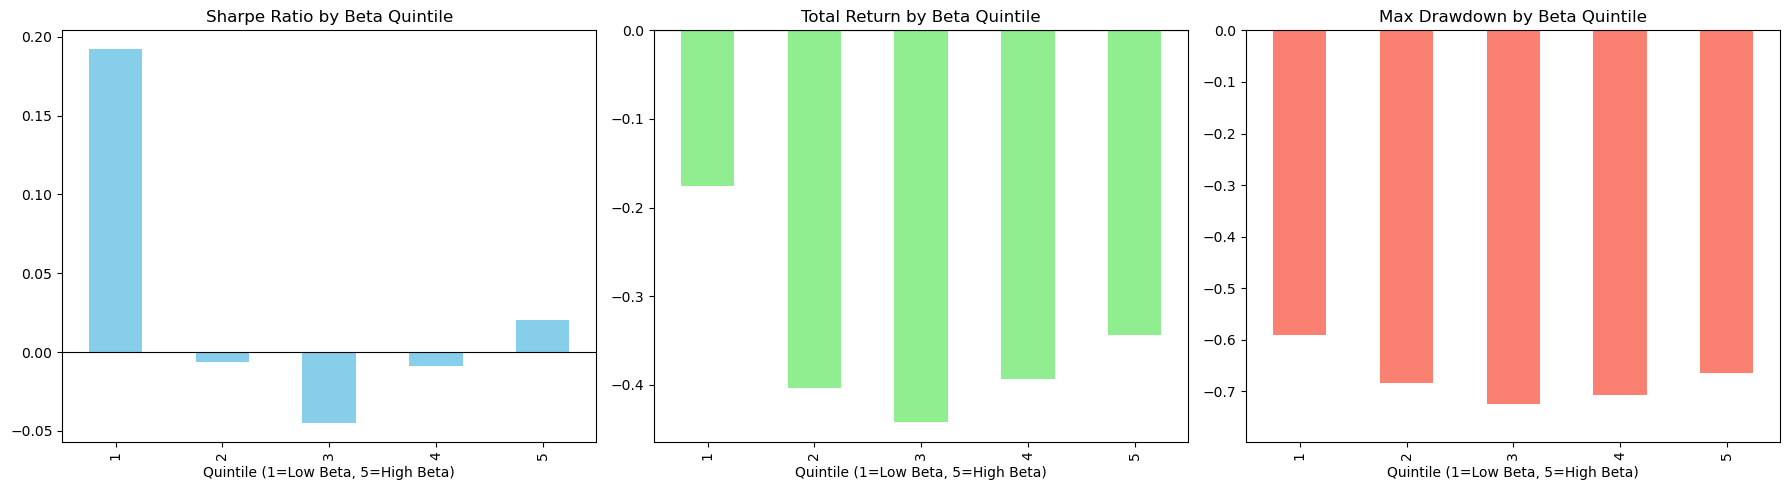

In [18]:
print("=== Performance by Beta Quintile (Long Only, Beta=1) ===")
# Format columns
display_cols = ["Quintile", "Description", "Sharpe", "Total Return", "Max Drawdown"]
styled_stats = stats_df[display_cols].style.format({
    "Sharpe": "{:.2f}",
    "Total Return": "{:.2%}",
    "Max Drawdown": "{:.2%}"
})
display(styled_stats)

# Plot Metrics Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

stats_df.plot(x="Quintile", y="Sharpe", kind="bar", ax=axes[0], color="skyblue", legend=False)
axes[0].set_title("Sharpe Ratio by Beta Quintile")
axes[0].set_xlabel("Quintile (1=Low Beta, 5=High Beta)")
axes[0].axhline(0, color='black', linewidth=0.8)

stats_df.plot(x="Quintile", y="Total Return", kind="bar", ax=axes[1], color="lightgreen", legend=False)
axes[1].set_title("Total Return by Beta Quintile")
axes[1].set_xlabel("Quintile (1=Low Beta, 5=High Beta)")
axes[1].axhline(0, color='black', linewidth=0.8)

stats_df.plot(x="Quintile", y="Max Drawdown", kind="bar", ax=axes[2], color="salmon", legend=False)
axes[2].set_title("Max Drawdown by Beta Quintile")
axes[2].set_xlabel("Quintile (1=Low Beta, 5=High Beta)")
axes[2].set_ylim(bottom=stats_df["Max Drawdown"].min() * 1.1, top=0) # Inverted for DD

plt.tight_layout()
plt.show()

# Visualize Cumulative Returns by Signal Strength
Generate a plot comparing the cumulative returns of the lowest beta quintile versus the highest beta quintile and others to visualize the "signal strength" of the beta factor. If BAB works, Q1 should be top and Q5 bottom.

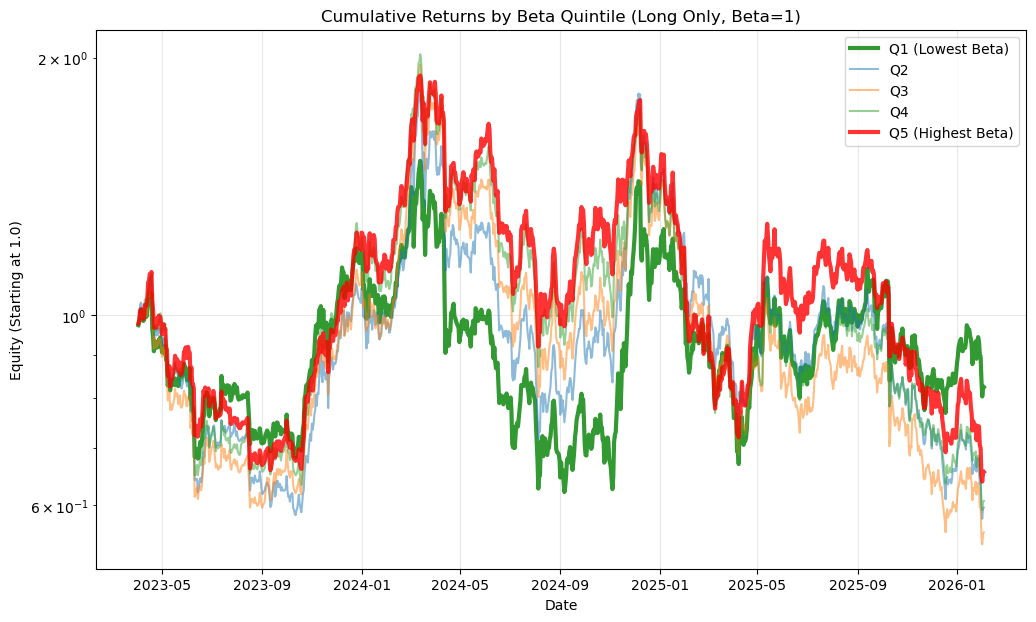

In [19]:
plt.figure(figsize=(12, 7))

for q, equity in quintile_results.items():
    if not equity.empty:
        label = f"Q{q+1} (Lowest Beta)" if q == 0 else (f"Q{q+1} (Highest Beta)" if q == n_quintiles-1 else f"Q{q+1}")
        
        # Style customization based on Q
        linestyle = '-'
        alpha = 0.8
        linewidth = 2
        
        if q == 0: color = 'green'; linewidth=3
        elif q == n_quintiles-1: color = 'red'; linewidth=3
        else: color = None; alpha=0.5; linewidth=1.5
        
        plt.plot(equity.index, equity, label=label, linewidth=linewidth, linestyle=linestyle, alpha=alpha, color=color if q in [0, n_quintiles-1] else None)

plt.title("Cumulative Returns by Beta Quintile (Long Only, Beta=1)")
plt.xlabel("Date")
plt.ylabel("Equity (Starting at 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log') # Log scale is often better for equity curves
plt.show()

# Visualize Q1 minus Q5 Spread (BAB Factor)
Construct a Long-Short spread portfolio by subtracting the returns of the Highest Beta quintile (Q5) from the Lowest Beta quintile (Q1). This represents the excess return of the Betting Against Beta factor.

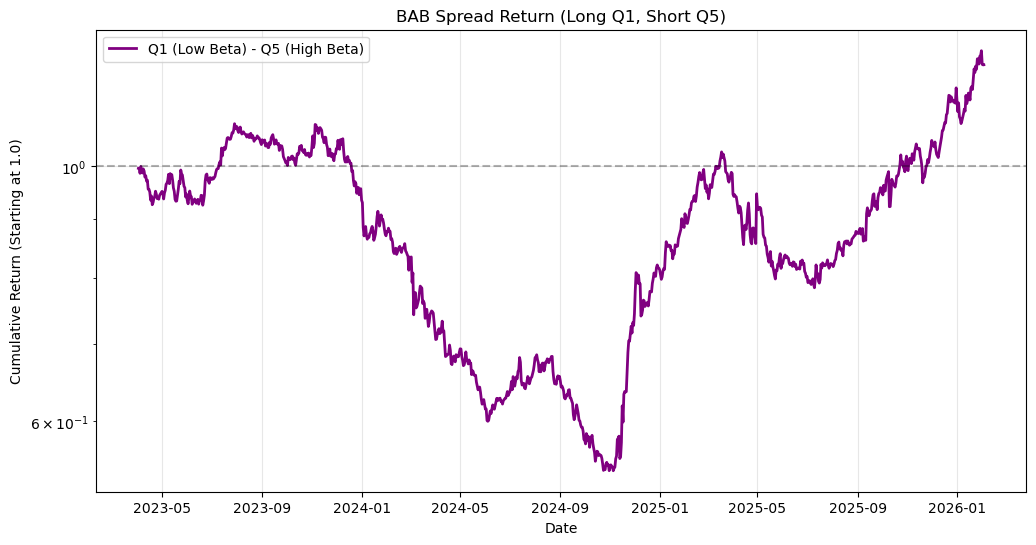

Spread Portfolio Stats (Long Q1 / Short Q5):
Total Return: 22.55%
Sharpe Ratio: 0.41
Max Drawdown: -50.09%


In [20]:
if 0 in quintile_returns and 4 in quintile_returns:
    ret_q1 = quintile_returns[0]
    ret_q5 = quintile_returns[4]
    
    # Ensure indices align
    common_idx = ret_q1.index.intersection(ret_q5.index)
    
    if not common_idx.empty:
        # Long Q1 (Low Beta), Short Q5 (High Beta)
        diff_series = ret_q1.loc[common_idx] - ret_q5.loc[common_idx]
        diff_equity = (1 + diff_series).cumprod()
        
        plt.figure(figsize=(12, 6))
        plt.plot(diff_equity.index, diff_equity.values, label="Q1 (Low Beta) - Q5 (High Beta)", color='purple', linewidth=2)
        plt.title("BAB Spread Return (Long Q1, Short Q5)")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return (Starting at 1.0)")
        plt.axhline(1.0, color='black', linestyle='--', alpha=0.3)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.yscale('log')
        plt.show()
        
        # Print Stats for Spread
        sharpe_diff = compute_sharpe(diff_series)
        total_ret_diff = diff_equity.iloc[-1] - 1.0
        
        running_max_diff = diff_equity.expanding().max()
        dd_diff = (diff_equity - running_max_diff) / running_max_diff
        max_dd_diff = dd_diff.min()
        
        print(f"Spread Portfolio Stats (Long Q1 / Short Q5):")
        print(f"Total Return: {total_ret_diff:.2%}")
        print(f"Sharpe Ratio: {sharpe_diff:.2f}")
        print(f"Max Drawdown: {max_dd_diff:.2%}")
    else:
        print("No overlapping data for Q1 and Q5.")
else:
    print("Q1 or Q5 data missing.")

# Minimum Variance Weighting Comparison
Now we run the same quintile analysis but using **Minimum Variance Optimization** within each quintile instead of Equal Weighting. 
This tests if optimizing for lower idiosyncratic risk within the low-beta bucket improves the Sharpe ratio further. We will maintain the same beta-scaling logic (Leverage to Beta=1.0).

In [21]:
import cvxpy as cvx
from beta_shrink_func import shrink_covariance_bayes

class BetaQuintileMinVarWeighting(BettingAgainstBetaWeighting):
    def __init__(self, target_quintile: int, n_quintiles: int = 5):
        super().__init__()
        self.target_quintile = target_quintile
        self.n_quintiles = n_quintiles

    def weights(self, idx, signals, bundle, universe_mask, params):
        beta = signals["beta"]
        
        # Filter for valid beta (Positive and Finite)
        valid_idx = np.where(universe_mask & np.isfinite(beta) & (beta > 0))[0]
        
        if len(valid_idx) < self.n_quintiles:
            return np.zeros(len(beta))
            
        beta_vals = beta[valid_idx]
        sorted_indices = valid_idx[np.argsort(beta_vals)]
        
        # Split into quintiles
        chunks = np.array_split(sorted_indices, self.n_quintiles)
        selected_indices = chunks[self.target_quintile]
        
        if len(selected_indices) < 2:
            return np.zeros(len(beta))
            
        # --- LONG-ONLY MIN VAR OPTIMIZATION ---
        beta_sel = beta[selected_indices]
        target_beta = params.target_side_beta
        tol = params.beta_tolerance
        lev_cap = getattr(params, "leverage_cap", 5.0)
        
        # Covariance matrix (shrunk) if enough history
        cov_mat = None
        if idx > 0:
            win_l = getattr(params, "covariance_window", 90)
            win_s = max(10, win_l // 3)
            
            start_l = max(0, idx - win_l)
            start_s = max(0, idx - win_s)
            
            hist_l = bundle.returns_df.iloc[start_l:idx]
            hist_s = bundle.returns_df.iloc[start_s:idx]
            
            if not hist_l.empty and not hist_s.empty:
                rets_l_long = hist_l.iloc[:, selected_indices]
                rets_l_short = hist_s.iloc[:, selected_indices]
                
                c_l_long = np.nan_to_num(rets_l_long.cov().to_numpy(), 0.0)
                c_l_short = np.nan_to_num(rets_l_short.cov().to_numpy(), 0.0)
                
                n_l = len(hist_l)
                n_s = len(hist_s)
                cov_mat = shrink_covariance_bayes(c_l_short, c_l_long, n_s, n_l)
                cov_mat += np.eye(len(selected_indices)) * 1e-6
        
        try:
            n_long = len(selected_indices)
            w_long = cvx.Variable(n_long, nonneg=True)
            
            if cov_mat is not None:
                obj = cvx.Minimize(cvx.quad_form(w_long, cov_mat))
            else:
                obj = cvx.Minimize(cvx.sum_squares(w_long))
            
            constr = [
                beta_sel @ w_long >= target_beta - tol,
                beta_sel @ w_long <= target_beta + tol,
                cvx.sum(w_long) <= lev_cap,
            ]
            
            if params.max_weight <= 1.0:
                constr.append(w_long <= params.max_weight)
            if params.min_weight > 0:
                constr.append(w_long >= params.min_weight)
            
            cvx.Problem(obj, constr).solve(solver=cvx.CLARABEL, verbose=False)
            
            if w_long.value is None:
                return np.zeros(len(beta))
            
            full_weights = np.zeros(len(beta))
            full_weights[selected_indices] = w_long.value
            full_weights[np.abs(full_weights) < 1e-8] = 0.0
            return full_weights
        except Exception:
            return np.zeros(len(beta))

class BetaQuintileFrazziniWeighting(BettingAgainstBetaWeighting):
    def __init__(self, target_quintile: int, n_quintiles: int = 5):
        super().__init__()
        self.target_quintile = target_quintile
        self.n_quintiles = n_quintiles

    def weights(self, idx, signals, bundle, universe_mask, params):
        beta = signals["beta"]
        volatility = signals.get("volatility", None)
        
        # Filter for valid beta (Positive and Finite)
        valid_idx = np.where(universe_mask & np.isfinite(beta) & (beta > 0))[0]
        
        if len(valid_idx) < self.n_quintiles:
            return np.zeros(len(beta))
        
        beta_vals = beta[valid_idx]
        sorted_indices = valid_idx[np.argsort(beta_vals)]
        
        # Split into quintiles
        chunks = np.array_split(sorted_indices, self.n_quintiles)
        selected_indices = chunks[self.target_quintile]
        
        if len(selected_indices) < 2:
            return np.zeros(len(beta))
        
        # Create mask for this quintile
        quintile_mask = np.zeros(len(beta), dtype=bool)
        quintile_mask[selected_indices] = True
        
        # Create dummy empty mask for shorts (Long Only)
        empty_mask = np.zeros(len(beta), dtype=bool)
        
        run_params = copy.copy(params)
        run_params.weighting_method = "frazzini_pedersen"
        
        return self._weights_frazzini_pedersen(
            beta=beta,
            long_mask=quintile_mask,
            short_mask=empty_mask,
            params=run_params,
            bundle=bundle,
            volatility=volatility
        )

In [22]:
minvar_results = {}
minvar_stats = []

frazzini_results = {}
frazzini_stats = []

for q in range(n_quintiles):
    print(f"\nRunning Min-Variance Backtest for Beta Quintile {q+1}/{n_quintiles}...")
    
    class SpecificMinVarWeighting(BetaQuintileMinVarWeighting):
        def __init__(self):
            super().__init__(target_quintile=q, n_quintiles=n_quintiles)
            
    runner = BABWalkForwardRunner(
        bundle=bundle,
        params_grid=[base_params], 
        train_span=90,
        test_span=90,
        step_span=90,
        score_mode="sharpe",
        mode='expanding'
    )
    
    runner.weighting_cls = SpecificMinVarWeighting
    
    # Run
    wf_df, oos_returns, oos_equity, _, _, _, _ = runner.run()
    
    minvar_results[q] = oos_equity
    
    # Stats
    if not oos_returns.empty:
        sharpe = compute_sharpe(oos_returns)
        total_ret = (oos_equity.iloc[-1] - 1.0) if not oos_equity.empty else 0.0
        max_dd = ((oos_equity - oos_equity.expanding().max()) / oos_equity.expanding().max()).min()
    else:
        sharpe = np.nan
        total_ret = 0.0
        max_dd = 0.0
        
    minvar_stats.append({
        "Quintile": q + 1,
        "Method": "Min Variance",
        "Sharpe": sharpe,
        "Total Return": total_ret,
        "Max Drawdown": max_dd
    })

    print(f"\nRunning Frazzini-Pedersen Backtest for Beta Quintile {q+1}/{n_quintiles}...")
    
    class SpecificFrazziniWeighting(BetaQuintileFrazziniWeighting):
        def __init__(self):
            super().__init__(target_quintile=q, n_quintiles=n_quintiles)
            
    runner = BABWalkForwardRunner(
        bundle=bundle,
        params_grid=[base_params], 
        train_span=90,
        test_span=90,
        step_span=90,
        score_mode="sharpe",
        mode='expanding'
    )
    
    runner.weighting_cls = SpecificFrazziniWeighting
    
    # Run
    wf_df, oos_returns, oos_equity, _, _, _, _ = runner.run()
    
    frazzini_results[q] = oos_equity
    
    # Stats
    if not oos_returns.empty:
        sharpe = compute_sharpe(oos_returns)
        total_ret = (oos_equity.iloc[-1] - 1.0) if not oos_equity.empty else 0.0
        max_dd = ((oos_equity - oos_equity.expanding().max()) / oos_equity.expanding().max()).min()
    else:
        sharpe = np.nan
        total_ret = 0.0
        max_dd = 0.0
        
    frazzini_stats.append({
        "Quintile": q + 1,
        "Method": "Frazzini-Pedersen",
        "Sharpe": sharpe,
        "Total Return": total_ret,
        "Max Drawdown": max_dd
    })

# Add EW stats for comparison
comparison_stats = []
comparison_stats.extend(minvar_stats)
comparison_stats.extend(frazzini_stats)

for stat in quintile_stats:
    stat_copy = stat.copy()
    stat_copy["Method"] = "Equal Weight"
    comparison_stats.append(stat_copy)

comparison_df = pd.DataFrame(comparison_stats)


Running Min-Variance Backtest for Beta Quintile 1/5...
BAB Iteration 1 (Expanding): Train [0:90], Test [90:179]
BAB Iteration 2 (Expanding): Train [0:180], Test [180:269]
BAB Iteration 3 (Expanding): Train [0:270], Test [270:359]
BAB Iteration 4 (Expanding): Train [0:360], Test [360:449]
BAB Iteration 5 (Expanding): Train [0:450], Test [450:539]
BAB Iteration 6 (Expanding): Train [0:540], Test [540:629]
BAB Iteration 7 (Expanding): Train [0:630], Test [630:719]
BAB Iteration 8 (Expanding): Train [0:720], Test [720:809]
BAB Iteration 9 (Expanding): Train [0:810], Test [810:899]
BAB Iteration 10 (Expanding): Train [0:900], Test [900:989]
BAB Iteration 11 (Expanding): Train [0:990], Test [990:1079]
BAB Iteration 12 (Expanding): Train [0:1080], Test [1080:1129]

Running Frazzini-Pedersen Backtest for Beta Quintile 1/5...
BAB Iteration 1 (Expanding): Train [0:90], Test [90:179]
BAB Iteration 2 (Expanding): Train [0:180], Test [180:269]
BAB Iteration 3 (Expanding): Train [0:270], Test [270:

=== Comparison: Equal Weight vs Min Variance vs Frazzini-Pedersen (Long Only, Beta=1) ===


,Quintile,Method,Sharpe,Total Return,Max Drawdown
10,1,Equal Weight,0.19,-17.55%,-59.00%
5,1,Frazzini-Pedersen,0.58,54.61%,-59.39%
0,1,Min Variance,-0.18,-55.47%,-70.02%
11,2,Equal Weight,-0.01,-40.38%,-68.42%
6,2,Frazzini-Pedersen,0.01,-40.21%,-73.42%
1,2,Min Variance,-0.22,-55.56%,-65.58%
12,3,Equal Weight,-0.05,-44.23%,-72.51%
7,3,Frazzini-Pedersen,-0.06,-46.79%,-75.03%
2,3,Min Variance,-0.03,-40.60%,-72.44%
13,4,Equal Weight,-0.01,-39.32%,-70.69%


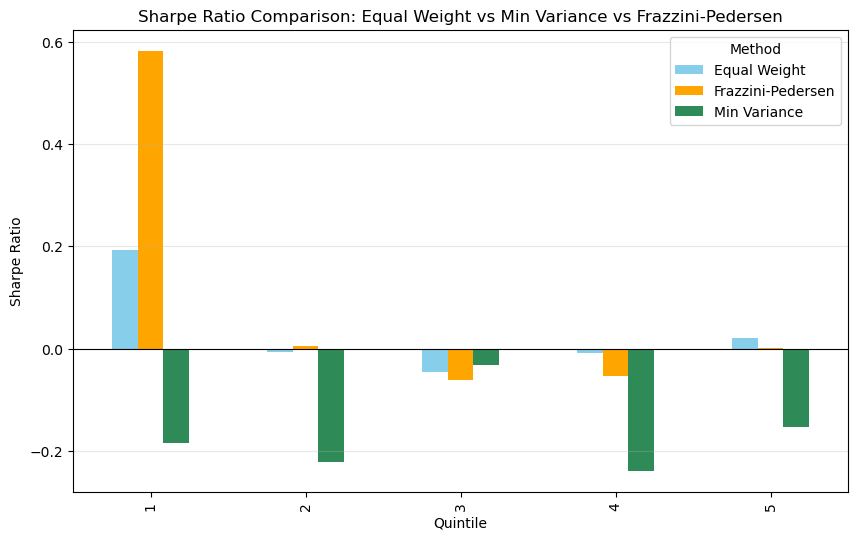

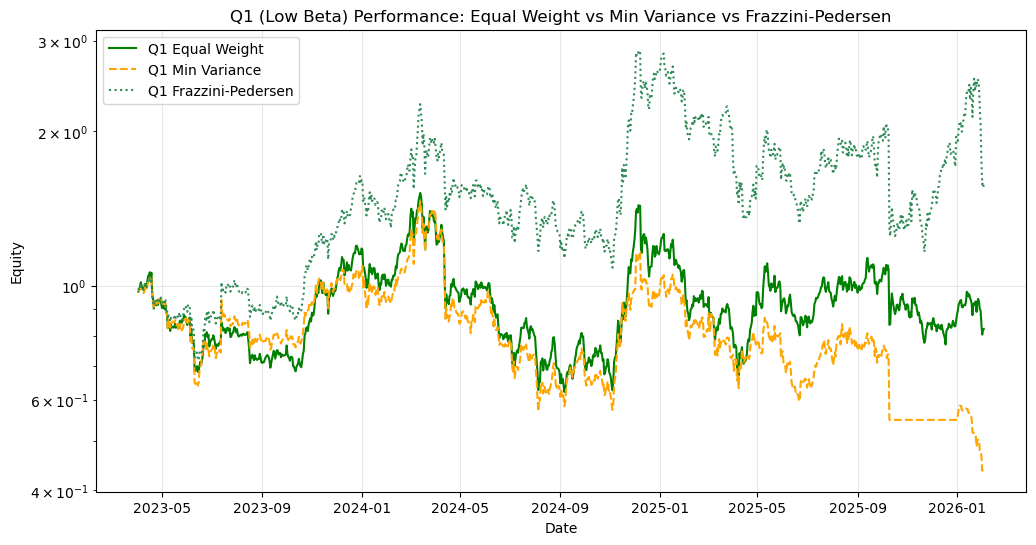

In [23]:
print("=== Comparison: Equal Weight vs Min Variance vs Frazzini-Pedersen (Long Only, Beta=1) ===")

# Sort for display
comparison_df = comparison_df.sort_values(by=["Quintile", "Method"])

styled_comp = comparison_df[["Quintile", "Method", "Sharpe", "Total Return", "Max Drawdown"]].style.format({
    "Sharpe": "{:.2f}",
    "Total Return": "{:.2%}",
    "Max Drawdown": "{:.2%}"
})
display(styled_comp)

# Comparative Bar Chart for Sharpe
pivot_sharpe = comparison_df.pivot(index="Quintile", columns="Method", values="Sharpe")
pivot_sharpe.plot(kind="bar", figsize=(10, 6), color=["skyblue", "orange", "seagreen"])
plt.title("Sharpe Ratio Comparison: Equal Weight vs Min Variance vs Frazzini-Pedersen")
plt.ylabel("Sharpe Ratio")
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Comparative Plot for Q1 (Lowest Beta)
if 0 in quintile_results and 0 in minvar_results and 0 in frazzini_results:
    ew_eq = quintile_results[0]
    mv_eq = minvar_results[0]
    fr_eq = frazzini_results[0]
    
    plt.figure(figsize=(12, 6))
    plt.plot(ew_eq.index, ew_eq.values, label="Q1 Equal Weight", color='green', linestyle="-")
    plt.plot(mv_eq.index, mv_eq.values, label="Q1 Min Variance", color='orange', linestyle="--")
    plt.plot(fr_eq.index, fr_eq.values, label="Q1 Frazzini-Pedersen", color='seagreen', linestyle=":")
    plt.title("Q1 (Low Beta) Performance: Equal Weight vs Min Variance vs Frazzini-Pedersen")
    plt.xlabel("Date")
    plt.ylabel("Equity")
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Min Variance Only Summary
Separate view of Min Variance results by quintile.

=== Min Variance Results Only (Long Only, Beta=1) ===


,Quintile,Sharpe,Total Return,Max Drawdown
0,1,-0.18,-55.47%,-70.02%
1,2,-0.22,-55.56%,-65.58%
2,3,-0.03,-40.60%,-72.44%
3,4,-0.24,-59.89%,-79.92%
4,5,-0.15,-48.03%,-71.07%


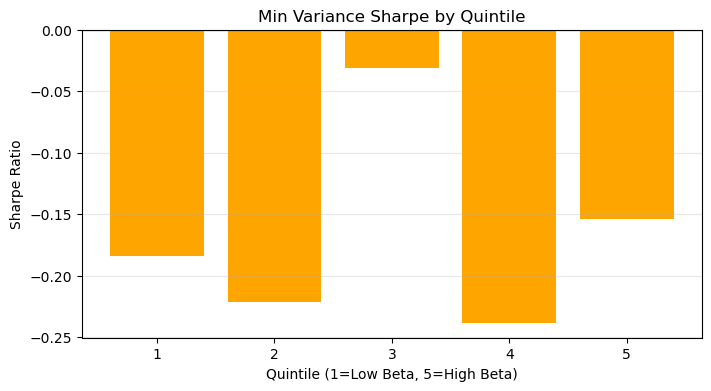

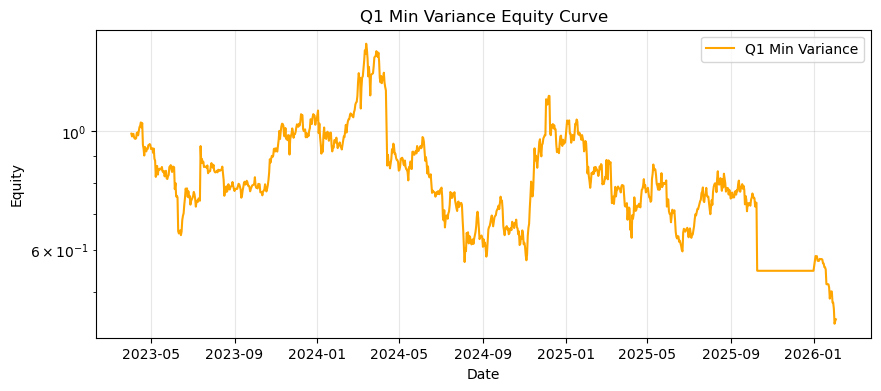

In [24]:
print("=== Min Variance Results Only (Long Only, Beta=1) ===")

mv_df = comparison_df[comparison_df["Method"] == "Min Variance"].copy()

if mv_df.empty:
    print("No Min Variance results found.")
else:
    mv_df = mv_df.sort_values("Quintile")
    styled_mv = mv_df[["Quintile", "Sharpe", "Total Return", "Max Drawdown"]].style.format({
        "Sharpe": "{:.2f}",
        "Total Return": "{:.2%}",
        "Max Drawdown": "{:.2%}"
    })
    display(styled_mv)

    # Plot Min Variance Sharpe by Quintile
    plt.figure(figsize=(8, 4))
    plt.bar(mv_df["Quintile"], mv_df["Sharpe"], color="orange")
    plt.title("Min Variance Sharpe by Quintile")
    plt.xlabel("Quintile (1=Low Beta, 5=High Beta)")
    plt.ylabel("Sharpe Ratio")
    plt.axhline(0, color='black', linewidth=0.8)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # Plot Min Variance Equity Curve for Q1 if available
    if 0 in minvar_results:
        mv_eq = minvar_results[0]
        if not mv_eq.empty:
            plt.figure(figsize=(10, 4))
            plt.plot(mv_eq.index, mv_eq.values, label="Q1 Min Variance", color="orange")
            plt.title("Q1 Min Variance Equity Curve")
            plt.xlabel("Date")
            plt.ylabel("Equity")
            plt.yscale('log')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.show()